In [2]:
%matplotlib inline
import os
import gym
import torch
import torch.nn as nn
from torch.distributions import Categorical
import numpy as np
from itertools import count
from matplotlib import pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


### Initialize environment

Actions Meaning ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Observation (210, 160, 3)


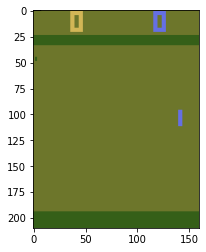

In [4]:
env = gym.make("Pong-v0")
observation = env.reset()
print("Actions Meaning", env.get_action_meanings())   # action meanings
print("Observation", env.observation_space.shape)     # Observation shape
# The ball is released after 20 frames
for i in range(22):
    if i > 20:
        plt.imshow(observation)
        plt.show()
        observation, _, _, _ = env.step(2)

### Preprocess the image

In [5]:
def state_to_tensor(I):
    if I is None: 
          return np.zeros(6400)  # if prev state = None, set it to np.zeros(6400)
    I = I[35:195]       # crop
    I = I[::2, ::2, 0]  # downsample by factor of 2
    I[I == 144] = 0     # erase background (background type 1)
    I[I == 109] = 0     # erase background (background type 2)
    I[I != 0] = 1       # everything else (paddles, ball) just set to 1
    return I

In [6]:
# get the state by sub current and previous states (images) and resize then to (1,1,80,80) to fit the Forward fun
def pre_process(cur_x, prev_x):
    return state_to_tensor(cur_x).reshape(1,1,80,80) - state_to_tensor(prev_x).reshape(1,1,80,80)

**Visulaize the environment after preprocessing**

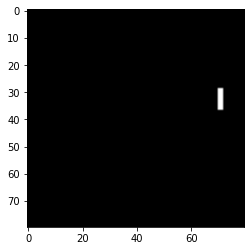

In [7]:
obs_preprocessed = state_to_tensor(observation).reshape(80,80)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

### Actor & Critic neutral network 

In [8]:
#actor neutral network
# returns the policy with the probability distribution over our actions
class PolicyNet(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(PolicyNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions),
            nn.Softmax(dim=1)
        )
     # get the output values from the convolution layer to pass this number to the first fully connected layer 
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    # accepts the 4D input tensor(batch size,color channel, image dimensions)
    def forward(self, x):
        conv_out = self.conv(x)
        fc_in = torch.reshape(conv_out, (conv_out.size(0), np.prod(conv_out.size()[1:])))
        x = self.fc(fc_in)
        dist = Categorical(x)
        return dist  

#critic neutral network
#returns one single number, which will approximate the state's value

class CriticNet(nn.Module):
    def __init__(self, input_shape):
        super(CriticNet, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x)
        fc_in = torch.reshape(conv_out, (conv_out.size(0), np.prod(conv_out.size()[1:])))
        x = self.fc(fc_in)
        return x    

### Discounted Reward

In [9]:
# each step sum reward for all steps which it has influenced
def discounted_returns(rewards, gamma=0.9):
    R = 0
    returns = list()
    for reward in reversed(rewards):
        if reward != 0: R=0      # reset the sum, since this was a game boundary (pong specific!)  
        R = reward + gamma * R   
        returns.insert(0, R)
    
    returns = torch.tensor(returns)
    return returns

### Initialize network & optimizer

In [10]:
## test the environment
action_size = env.action_space.n
input_shape = [1,80,80]

## initialize the net
pnet = PolicyNet(input_shape, action_size).to(device)
cnet = CriticNet(input_shape).to(device)

## initialize an optimizer
p_optimizer = torch.optim.Adam(pnet.parameters(), lr=1e-4)
c_optimizer = torch.optim.Adam(cnet.parameters(), lr=1e-4)

### Main program

In [13]:
running_reward = None
best_reward = -10

for e in range(2000):
    action_log_probs = list()
    rewards = list()
    values = list()
    state = env.reset()  # current state
    prev_x = None        # previous state

    for t in range(100000):
        # preprocess the observation, set input to network to be difference image
        x = pre_process(state,prev_x)   
        # set the current state as previous state 
        prev_x = state 
        # convert the state into a PyTorch tensor, copy it into (GPU) and forward the actor network
        action_prob = pnet(torch.FloatTensor(x).to(device))
        #sample an action from the returned probability
        action = action_prob.sample()            
        # get the log value of this action               
        action_log_probs.append(action_prob.log_prob(action))    
        # forward the critic network and get a value for the action taken
        value = cnet(torch.FloatTensor(x).to(device))            
        values.append(value[0])
        # step the environment and get new measurements
        next_state, reward, is_done, _ = env.step(action.item()) 
        # record reward (has to be done after we call step() to get reward for previous action)
        rewards.append(reward)         
        # set current state as next state
        state = next_state             

        if is_done:

            break

    # compute the discounted reward
    returns = discounted_returns(rewards)           
    action_losses = list()
    critic_losses = list()

     # collect the action losses to a list
    for ret, l_prob, v in zip(returns, action_log_probs, values):
     # this tells us how much better it is to take a specific action compared to the average        
        advantage = ret - v                             
     # policy gradients equal to probability for the actions taken scaled with advantage 
        action_losses.append(-l_prob * advantage.detach())            
        critic_losses.append(advantage.pow(2))                        

    p_optimizer.zero_grad()                                           
    action_loss = torch.cat(action_losses).sum()
    action_loss.backward()
    p_optimizer.step()

    c_optimizer.zero_grad()
    critic_loss = torch.cat(critic_losses).mean()
    critic_loss.backward()                                     # backpropagation 
    c_optimizer.step()                                         # update the network
    
    ep_reward = sum(rewards)  

    # print last and average reward          
    running_reward = ep_reward if running_reward is None else running_reward * 0.99 + ep_reward * 0.01
    print('Episode: %d Last Reward: %.2f Avg Reward: %.2f' % (e, ep_reward, running_reward))  

Episode: 0 Last Reward: -21.00 Avg Reward: -21.00
Episode: 1 Last Reward: -19.00 Avg Reward: -20.98
Episode: 2 Last Reward: -19.00 Avg Reward: -20.96
Episode: 3 Last Reward: -20.00 Avg Reward: -20.95
Episode: 4 Last Reward: -19.00 Avg Reward: -20.93
Episode: 5 Last Reward: -20.00 Avg Reward: -20.92
Episode: 6 Last Reward: -19.00 Avg Reward: -20.90
Episode: 7 Last Reward: -20.00 Avg Reward: -20.89
Episode: 8 Last Reward: -21.00 Avg Reward: -20.89
Episode: 9 Last Reward: -21.00 Avg Reward: -20.90
Episode: 10 Last Reward: -20.00 Avg Reward: -20.89
Episode: 11 Last Reward: -21.00 Avg Reward: -20.89
Episode: 12 Last Reward: -19.00 Avg Reward: -20.87
Episode: 13 Last Reward: -20.00 Avg Reward: -20.86
Episode: 14 Last Reward: -21.00 Avg Reward: -20.86
Episode: 15 Last Reward: -20.00 Avg Reward: -20.85
Episode: 16 Last Reward: -21.00 Avg Reward: -20.85
Episode: 17 Last Reward: -21.00 Avg Reward: -20.86
Episode: 18 Last Reward: -19.00 Avg Reward: -20.84
Episode: 19 Last Reward: -21.00 Avg Rewar